# Calculate skill scores for offline tracer advection with ROMS



## TODOS

* cast in terms of normalized time scale also
* DONE print final ss for all relevant runs
 * which runs to just say in text
  * avg vs his
  * Aksoff different background values
* DONE plot ss vs run time vs storage time as a 3d plot or line plot with contours
 * how to present storage normalized. As a function of number of grid nodes horizontally and vertically (since some variables are 3d and some 4d)
 * xaxis: time per time step per core, 
 * y axis: required storage normalized by horizontal and vertical number of nodes per time step, 
 * z contour: skill score. Have Akson and Aksoff separate lines.
 * check on time required for MPDATA vs. U3C4.
* DONE calculate tracer conservation on and offline
 * online one of the runs MPDATA and U3C4, then compare with highest offline (nhis1) and with nhis500/dt1/10/20
* DONE do a run to compare 64 bit and not 64 bit
 * which run? nhis=500 online, several dt (1, 10, 20) offline, MPDATA, Akson, his. Adding suffix "single"
* DONE give run time per core as long as logfile shows that one of the categories showing core isn't bad
* SKIPPING Why are results from U3C4 so different from MPDATA in terms of nhis and dt lack of dependence?
 * run MPDATA offline with U3C4 online, and U3C4 offline with MPDATA online
 * Use nhis 500, dt20
 
 
Results for paper:
* Plot of skill score as I have it but with normalization.
 * also keep regular axes in notebook for reference
 * Keep plot of skill score vs persistence with normalization
* Plot showing several smaller results:
 * Plot persistence skill score for one example case
 * Forcing on and offline with opposite advection schemes
 * single vs double precision
* Just state in text:
 * his vs avg file forcing
 * tracer conservation


In [1]:
import xarray as xr
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from glob import glob
import pandas as pd
import os
# import hvplot.xarray
# import geoviews as gv
import cartopy
import cmocean.cm as cmo
import netCDF4 as netCDF
import xgcm

# chunks = {'ocean_time': 50}#, 's_rho': 50}
chunks = {'ocean_time': 1}
# chunks = {'s_rho': 1}

# chunks = {'s_rho': 1}

/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
import dask
from dask.distributed import Client

# client = Client(n_workers=7, threads_per_worker=2)#, memory_limit='20GB')
client = Client()#, memory_limit='20GB')
# client = Client(n_workers=1, threads_per_worker=7)  # i have multiple cores on one machine so use threads
client

Client Scheduler: tcp://127.0.0.1:34801 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 21.47 GB


In [3]:
baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'

# plot parameters
fss = 12
fsm = 14
fsb = 16
ms = 150

iy = [10,75]; ix = [5,115]

tend=13.5

nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
dts = [1,2,5,10,20]
whichadvects = ['U3C4','MPDATA']
akss = [1e-6, 1e-3]  # vary background Aks values when Aks isn't being forced directly
aksflags = ['Akson', 'Aksoff']
clminputs = ['his', 'avg']

In [4]:
def add_depths(ds):
#     Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
#     z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho', transpose_coords=False)
#     ds.coords['z_rho'] = z_rho.transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho', transpose_coords=False)
    return ds

def setup_grid(ds):
    # Create the grid
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
        'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
        's':{'center':'s_rho', 'outer':'s_w'}}

    grid = xgcm.Grid(ds, coords=coords, periodic=[])
    return ds, grid

# Scales to use for normalization

In [5]:
# example model output to use for a few things
locon = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_his.nc'
ds = xr.open_dataset(locon, decode_times=False, chunks=chunks)
ds['ocean_time'] = (ds.ocean_time - ds.ocean_time[0])/86400

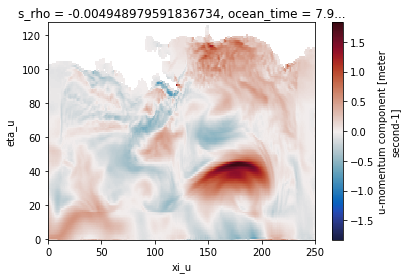

In [6]:
ds.u.isel(s_rho=-1).sel(ocean_time=8, method='nearest').plot(cmap=cmo.balance)

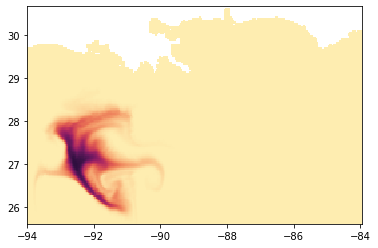

In [7]:
plt.pcolormesh(ds.lon_rho, ds.lat_rho, ds.dye_01.isel(s_rho=-1).sel(ocean_time=8, method='nearest'), cmap=cmo.matter)

In [8]:
L = 10000  # m
U = 0.5  # m/s

T = L/U  # normalized advection time in seconds
T

20000.0

# Map of initial dye blob

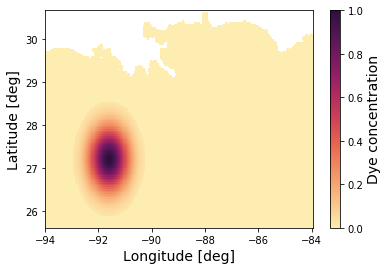

In [202]:
plt.pcolormesh(ds.lon_rho, ds.lat_rho, ds.dye_01.isel(s_rho=-1).sel(ocean_time=0, method='nearest'), cmap=cmo.matter)
cb = plt.colorbar()
cb.set_label('Dye concentration', fontsize=fsm)
plt.xlabel('Longitude [deg]', fontsize=fsm)
plt.ylabel('Latitude [deg]', fontsize=fsm)

plt.savefig('figures/map_low.png', bbox_inches='tight', dpi=100)
plt.savefig('figures/map.png', bbox_inches='tight', dpi=300)

## Set up parameters for simulations





## Read in on and offline output


Times

nhis 100, dt 10
4, 4, 28, 27
dyeon.nbytes/1e9 = 1.7303GB
0.034606GB surface only

nhis 10, dt 10
45, 40, surface only, time chunk 10: 30, 30, 80, 200
time chunk 50: 25, 40, 70, 200
dyeon.nbytes/1e9=17GB, 0.3460028 surface only
dyeon.isel(ocean_time=0).nbytes/1e9 = 0.00286



First downscale all the online files, which have potential very high output rates.

In [9]:


nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
whichadvects = ['U3C4']#,'MPDATA']
clminputs = ['his']#, 'avg']


for i, nhis in enumerate(nhiss):
    dd = int(500/nhis)
    if nhis>500:  # for nhis=1000,2000,5000, output is at that frequency which is lower than 500
        dd = 1
        
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for clminput in clminputs:
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s.nc' % (baseon,whichadvect,nhis,clminput)
            zarrname = locon.split('.')[0]
            print(zarrname)
            
            if not os.path.exists(zarrname):  # don't redo
                print('processing...')
                dson = xr.open_dataset(locon, decode_times=False, chunks=chunks);

                dson = add_depths(dson)
                dson, grid = setup_grid(dson)  
                dzon = grid.diff(dson.z_w, 's')

                dx = 1/dson.pm
                dy = 1/dson.pn
                dyeon = (dson['dye_01']*dx*dy*dzon)

                dyeon.isel(ocean_time=slice(0,-1,dd), eta_rho=slice(iy[0],iy[1]), 
                           xi_rho=slice(ix[0],ix[1])).to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
            else:
                print('already done, moving on.\n')


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis5/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis10/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis20/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis50/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis100/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis200/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1000/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3

In [12]:
# tend = 13.5

# locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis1/oil_off_his_dt1.nc'
# dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
# dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
# dfhis = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)


# locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1/oil_off_avg_dt1.nc'
# dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
# dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
# dfavg = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)


In [34]:
locson = []; locsoff = []

# Put together lists of locations to compare with skill score
for clminput in clminputs:
    for whichadvect in whichadvects:
        for i, nhis in enumerate(nhiss):
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)
            
            # loop over sim time step
            for dt in dts:
                
                if dt>nhis:
                    continue
                elif nhis == 50 and dt == 20:
                    continue
                elif nhis == 5 and dt == 2:
                    continue

                # Aks forcing can be turned on or off
                for aksflag in aksflags:
                    if aksflag == 'Aksoff':
                        for aks in akss:

                            exp = int(abs(np.log10(aks)))
                            outdir = '%s/output_ss/%s/%s/Aksbak%i/%s/nhis%i' % (baseoff,whichadvect,aksflag,exp,clminput,nhis)                                
                            locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                            print(locoff)
                            if not os.path.exists(locoff):
                                print('%s does not exist\n' % locoff)
                            else:
                                # always append locson at same time as locsoff to match one to one
                                locson.append(locon)
                                locsoff.append(locoff)
                    else:
                        outdir = '%s/output_ss/%s/%s/%s/nhis%i' % (baseoff,whichadvect,aksflag,clminput,nhis)
                        locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                        print(locoff)
                        if not os.path.exists(locoff):
                            print('%s does not exist\n' % locoff)
                        else:
                            # always append locson at same time as locsoff to match one to one
                            locson.append(locon)
                            locsoff.append(locoff)


/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_of

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt2.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis200/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt5.nc does n

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis500/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis500/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis500/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis1000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis1000/oil_off_his_dt1.nc
/scratch/group/csom

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis2/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis2/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis5/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis5/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis5/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis500/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis500/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis1000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1000/oil_off_avg_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1000/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis1000/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1000/oil_off_avg_dt2.nc
/

In [126]:
ind = np.arange(0, 13.5, 500*20/86400)

def calc_denom(locon, which):
    if which == 'regular':
        denomname = '%s_denom.csv' % locon
    elif which == 'persistence':
        denomname = '%s_denom_persist.csv' % locon
        
    if os.path.exists(denomname):
        denom = pd.read_csv(denomname, index_col='ocean_time')
    else:
        dson = xr.open_zarr(locon, decode_times=False)
        
        if which == 'regular':
            # calculate denominator for skill score 
            denom = np.sqrt(((dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))
        elif which == 'persistence':
            # compare online vs initial time step for persistence as a climatology
            denom = np.sqrt(((dson.dye_01.isel(ocean_time=0) - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

        # save 
        denom = denom.to_dataframe(name='denom')
        denom.to_csv(denomname)  
        dson.close()
    return denom

    
def calc_num(locon, locoff):
    numname = '%s_num.csv' % locoff.split('.')[0]

    if os.path.exists(numname):
        num = pd.read_csv(numname, index_col='ocean_time')
    else:

        dson = xr.open_zarr(locon, decode_times=False)

        dsoff = xr.open_dataset(locoff, decode_times=False)
        dsoff = add_depths(dsoff)
        dsoff, grid = setup_grid(dsoff)  
        dzoff = grid.diff(dsoff.z_w, 's')
        dx = 1/dsoff.pm
        dy = 1/dsoff.pn
        dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
        dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                    xi_rho=slice(ix[0],ix[1]))
        # interpolate to match online run
        dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

        num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))
        num = num.to_dataframe(name='num')
        num.to_csv(numname)
        dsoff.close()
    return num


def calc_ss(ssname, num, denom):

    if os.path.exists(ssname):
        skill = pd.read_csv(ssname, index_col='ocean_time')
    else:
        skill = (1-num/denom.values)*100
        skill.index = (skill.index - skill.index[0])/86400
        skill.to_csv(ssname)
    return skill


def newcol(locoff, ss, which):
    
    # find column name
    if 'Aksbak' in locoff:
        whichadvect, aksflag, Aksbak, clminput, nhispart, dtpart = locoff.split('/')[7:]
        colname = '%s_%s_%s_%s_%s_%s_%s' % (whichadvect, aksflag, Aksbak, clminput, nhispart, 
                                            dtpart.split('_')[-1].split('.')[0],
                                            which)
    else:
        whichadvect, aksflag, clminput, nhispart, dtpart = locoff.split('/')[7:]
        colname = '%s_%s_%s_%s_%s_%s' % (whichadvect, aksflag, clminput, nhispart, 
                                            dtpart.split('_')[-1].split('.')[0],
                                            which)
    
    # create cols
    ss = ss.reindex(ind).interpolate('index')  # made sure times match here

    return colname, ss['num'].values

In [146]:
cols = np.zeros((ind.size, len(locson)))
colnames = []
colsp = np.zeros((ind.size, len(locson)))
colnamesp = []
for i, (locon, locoff) in enumerate(zip(locson, locsoff)):
    print(locon, locoff)

    ## calculate denominator from online output ##
    denom = calc_denom(locon, 'regular')
    denomp = calc_denom(locon, 'persistence')
    
    # calculate numerator
    num = calc_num(locon, locoff)
    
    # calculate skill scores
    ssname = '%s_ss.csv' % locoff.split('.')[0]
    ss = calc_ss(ssname, num, denom)
    ssname = '%s_ss_persist.csv' % locoff.split('.')[0]
    ssp = calc_ss(ssname, num, denomp)
    
    # create new col containing skill score
    name, col = newcol(locoff, ss, 'reg')
    cols[:,i] = col
    colnames.append(name)
    name, col = newcol(locoff, ss, 'persist')
    colsp[:,i] = col
    colnamesp.append(name)

df = pd.DataFrame(index=ind, data=np.concatenate((cols,colsp), axis=1), columns=colnames+colnamesp)
df

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt5.nc
/scratch/group/cso

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis5/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis10/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis10/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis10/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis10/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis10/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis10/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis10/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis10/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis10/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis10/oil_off_his_dt2.nc


/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis200/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis200/oil_o

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5000/oil_03_his /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis1/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2/oil_off_avg_dt1.nc
/scra

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis100/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis100/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis100/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis100/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis100/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis100/oil_o

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2000/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2000/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2000/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2000/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2000/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2000/oil_03_avg /scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2000/

,U3C4_Akson_his_nhis1_dt1_reg,U3C4_Aksoff_Aksbak6_his_nhis1_dt1_reg,U3C4_Akson_his_nhis2_dt1_reg,U3C4_Aksoff_Aksbak6_his_nhis2_dt1_reg,U3C4_Akson_his_nhis2_dt2_reg,U3C4_Aksoff_Aksbak6_his_nhis2_dt2_reg,U3C4_Akson_his_nhis5_dt1_reg,U3C4_Aksoff_Aksbak6_his_nhis5_dt1_reg,U3C4_Akson_his_nhis5_dt5_reg,U3C4_Aksoff_Aksbak6_his_nhis5_dt5_reg,...,MPDATA_Akson_avg_nhis5000_dt1_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt1_persist,MPDATA_Akson_avg_nhis5000_dt2_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt2_persist,MPDATA_Akson_avg_nhis5000_dt5_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt5_persist,MPDATA_Akson_avg_nhis5000_dt10_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt10_persist,MPDATA_Akson_avg_nhis5000_dt20_persist,MPDATA_Aksoff_Aksbak6_avg_nhis5000_dt20_persist
0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,97.951695,97.950650,97.951330,97.950284,97.950234,97.949185,97.948400,97.947346,97.944702,97.943639
0.115741,99.995411,99.987793,99.995411,99.987793,99.995411,99.987793,99.995411,99.987793,99.995411,99.987793,...,97.607380,97.604994,97.607029,97.604642,97.605975,97.603585,97.604211,97.601816,97.600650,97.598245
0.231481,99.990823,99.975586,99.990823,99.975586,99.990822,99.975586,99.990823,99.975586,99.990822,99.975586,...,97.263064,97.259338,97.262728,97.259001,97.261716,97.257986,97.260022,97.256286,97.256598,97.252851
0.347222,99.986234,99.963379,99.986234,99.963379,99.986234,99.963379,99.986234,99.963379,99.986233,99.963379,...,96.918749,96.913682,96.918427,96.913359,96.917458,96.912386,96.915833,96.910756,96.912546,96.907458
0.462963,99.982296,99.949052,99.982296,99.949052,99.982296,99.949052,99.982296,99.949052,99.982294,99.949051,...,96.574433,96.568026,96.574126,96.567717,96.573199,96.566787,96.571644,96.565226,96.568494,96.562064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12.962963,99.622409,97.551632,99.622409,97.551632,99.622408,97.551633,99.622408,97.551632,99.622402,97.551635,...,77.904843,77.728136,77.910728,77.734057,77.927974,77.751528,77.955798,77.779941,78.008848,77.834231
13.078704,99.619564,97.559178,99.619564,97.559178,99.619562,97.559179,99.619563,97.559178,99.619557,97.559182,...,77.904843,77.728136,77.910728,77.734057,77.927974,77.751528,77.955798,77.779941,78.008848,77.834231
13.194444,99.616718,97.566724,99.616718,97.566724,99.616717,97.566725,99.616717,97.566725,99.616711,97.566728,...,77.904843,77.728136,77.910728,77.734057,77.927974,77.751528,77.955798,77.779941,78.008848,77.834231
13.310185,99.613877,97.567743,99.613877,97.567743,99.613876,97.567744,99.613877,97.567743,99.613871,97.567746,...,77.904843,77.728136,77.910728,77.734057,77.927974,77.751528,77.955798,77.779941,78.008848,77.834231


In [13]:


for clminput in clminputs:
    
    if clminput == 'his':
        df = dfhis
    elif clminput == 'avg':
        df = dfavg
    dfname = 'output_ss/df%s.csv' % clminput
           
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for i, nhis in enumerate(nhiss):
            if nhis>500:
                dd = 1
            else:
                dd = int(500/nhis)
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)
            dson = xr.open_zarr(locon, decode_times=False)#, chunks=chunks)

            print(locon)            
            
            denomname = '%s_denom.csv' % locon
           
            if os.path.exists(denomname):
                denom = pd.read_csv(denomname, index_col='ocean_time')
            else:
                # calculate denominator for skill score which is the same for all derivative offline runs
                denom = np.sqrt(((dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                # save 
                denom = denom.to_dataframe(name='denom')
                denom.to_csv(denomname)           
                                
            # loop over sim time step
            for dt in dts:
                
                if dt>nhis:
                    continue
                elif nhis == 50 and dt == 20:
                    continue
                elif nhis == 5 and dt == 2:
                    continue

                # Aks forcing can be turned on or off
                for aksflag in aksflags:
                    if aksflag == 'Aksoff':
                        for aks in akss:

                            exp = int(abs(np.log10(aks)))
                            outdir = '%s/output_ss/%s/%s/Aksbak%i/%s/nhis%i' % (baseoff,whichadvect,aksflag,exp,clminput,nhis)                                
                            locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                            print(locoff)
                            
                            if not os.path.exists(locoff):
                                print('%s does not exist\n' % locoff)
                            else:
                                
                                name = '%s_%s_Aksbak%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,exp,clminput,nhis,dt)
                                numname = '%s_num.csv' % locoff.split('.')[0]  # num same for persist

                                if os.path.exists(numname):
                                    num = pd.read_csv(numname, index_col='ocean_time')
                                else:

                                    dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
                                    dsoff = add_depths(dsoff)
                                    dsoff, grid = setup_grid(dsoff)  
                                    dzoff = grid.diff(dsoff.z_w, 's')
                                    dx = 1/dsoff.pm
                                    dy = 1/dsoff.pn
                                    dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                                    dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                                xi_rho=slice(ix[0],ix[1]))
                                    # interpolate to match online run
                                    dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                                    num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))
                                    num = num.to_dataframe(name='num')
                                    num.to_csv(numname)

                                ssname = '%s_ss.csv' % locoff.split('.')[0]

                                if os.path.exists(ssname):
                                    skill = pd.read_csv(ssname, index_col='ocean_time')
                                else:
                                    skill = (1-num/denom.values)*100
                                    skill.index = (skill.index - skill.index[0])/86400
                                    skill.to_csv(ssname)

                                df[name] = skill[0:tend]
                                df[name] = df[name].interpolate(method='index')

                    else:
                        outdir = '%s/output_ss/%s/%s/%s/nhis%i' % (baseoff,whichadvect,aksflag,clminput,nhis)
                        locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                        print(locoff)
                        if not os.path.exists(locoff):
                            print('%s does not exist\n' % locoff)
                        else:
                            name = '%s_%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,clminput,nhis,dt)
                            numname = '%s_num.csv' % locoff.split('.')[0]  # num same for persist

                            if os.path.exists(numname):
                                num = pd.read_csv(numname, index_col='ocean_time')
                            else:

                                dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
                                dsoff = add_depths(dsoff)
                                dsoff, grid = setup_grid(dsoff)  
                                dzoff = grid.diff(dsoff.z_w, 's')
                                dx = 1/dsoff.pm
                                dy = 1/dsoff.pn
                                dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                                dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                            xi_rho=slice(ix[0],ix[1]))
                                # interpolate to match online run
                                dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                                num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))
                                num = num.to_dataframe(name='num')
                                num.to_csv(numname)

                            ssname = '%s_ss.csv' % locoff.split('.')[0]

                            if os.path.exists(ssname):
                                skill = pd.read_csv(ssname, index_col='ocean_time')# np.loadtxt(ssname)
                            else:
                                skill = (1-num/denom.values)*100
                                skill.index = (skill.index - skill.index[0])/86400
                                skill.to_csv(ssname)

                            df[name] = skill[0:tend]
                            df[name] = df[name].interpolate(method='index')

    df.to_csv(dfname)


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt5.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis100/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt10.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis100/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt20.nc

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt5.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2000/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt10.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2000/oil_off_h

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis50/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis50/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis50/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis50/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis100/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis100/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis100/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis100/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis100/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Ak

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt10.nc does not exist

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis2000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis2000/oil_off_his_dt20.nc does not exist

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5000/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis5000/oil_off_his_dt1.n

ValueError: group not found at path ''

### Print out final skill score for a large subset of runs

Don't show avg runs or multiple background Aks value runs

In [7]:
fname = 'output_ss/dfhis.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')

In [16]:
pd.set_option('display.max_rows', None)
cols = [col for col in dfhis.columns if 'dt50' not in col and 'Aksbak3' not in col]
print(dfhis[cols].iloc[-1])
pd.set_option('display.max_rows', 6)

U3C4_Akson_his_nhis1_dt1                   91.713118
U3C4_Aksoff_Aksbak6_his_nhis1_dt1          91.353124
U3C4_Akson_his_nhis2_dt1                   91.713119
U3C4_Aksoff_Aksbak6_his_nhis2_dt1          91.353125
U3C4_Akson_his_nhis2_dt2                   91.713113
U3C4_Aksoff_Aksbak6_his_nhis2_dt2          91.353125
U3C4_Akson_his_nhis5_dt1                   91.713119
U3C4_Aksoff_Aksbak6_his_nhis5_dt1          91.353126
U3C4_Akson_his_nhis10_dt1                  91.713125
U3C4_Aksoff_Aksbak6_his_nhis10_dt1         91.353132
U3C4_Akson_his_nhis10_dt2                  91.713119
U3C4_Aksoff_Aksbak6_his_nhis10_dt2         91.353132
U3C4_Akson_his_nhis10_dt5                  91.713100
U3C4_Aksoff_Aksbak6_his_nhis10_dt5         91.353134
U3C4_Akson_his_nhis10_dt10                 91.713069
U3C4_Aksoff_Aksbak6_his_nhis10_dt10        91.353138
U3C4_Akson_his_nhis20_dt1                  91.713149
U3C4_Aksoff_Aksbak6_his_nhis20_dt1         91.353153
U3C4_Akson_his_nhis20_dt2                  91.

## Calculate skill score compared to persistence

save num and denom each time

In [414]:
tend = 13.5

locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis1/oil_off_his_dt1.nc'
dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
dfhis = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)

locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis1/oil_off_avg_dt1.nc'
dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
dfavg = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)


In [415]:
iy = [10,75]; ix = [5,115]

nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
whichadvects = ['U3C4','MPDATA']
dts = [1,2,5,10,20]
akss = [1e-6, 1e-3]  # vary background Aks values when Aks isn't being forced directly
aksflags = ['Akson', 'Aksoff']
clminputs = ['his', 'avg']

baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'


for clminput in clminputs:
    
    if clminput == 'his':
        df = dfhis
    elif clminput == 'avg':
        df = dfavg
        
    dfname = 'output_ss/df%s_persist.csv' % clminput
           
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for i, nhis in enumerate(nhiss):
            dd = int(500/nhis)
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)
            dson = xr.open_zarr(locon, decode_times=False)#, chunks=chunks)
#             dson['ocean_time'] = (dson.ocean_time - dson.ocean_time[0])/86400
            print(locon)
            
            denomname = '%s_denom_persist.csv' % locon
           
            if os.path.exists(denomname):
                denom = pd.read_csv(denomname, index_col='ocean_time')# np.loadtxt(denomname)
            else:
                # calculate denominator for skill score which is the same for all derivative offline runs
                # compare online vs initial time step for persistence as a climatology
                denom = np.sqrt(((dson.dye_01.isel(ocean_time=0) - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                # save 
                denom = denom.to_dataframe(name='denom')
                denom.to_csv(denomname)
            
            # for each nhis, the possible time step dts to run is from 1 up to equal to clm
            dts = nhiss[:i+1]
            
            if nhis == 5:
                dts = [1]
            elif nhis == 50:
                dts = [1,2,5,10]
                
            # loop over sim time step
            for dt in dts:

            
                if dt >= 50:  # dt=100 creates instabilities and results are invalid
                    continue

                # Aks forcing can be turned on or off
                for aksflag in aksflags:
                    if aksflag == 'Aksoff':

                        for aks in akss:
                            if nhis>=1000 and aks == 1e-3:
                                continue
                            exp = int(abs(np.log10(aks)))
                            outdir = '%s/output_ss/%s/%s/Aksbak%i/%s/nhis%i' % (baseoff,whichadvect,aksflag,exp,clminput,nhis)                                
                            locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                            print(locoff)
                            name = '%s_%s_Aksbak%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,exp,clminput,nhis,dt)
                            
                            numname = '%s_num.csv' % locoff.split('.')[0]
                            
                            if os.path.exists(numname):
                                num = pd.read_csv(numname, index_col='ocean_time')# np.loadtxt(numname)
                            else:
                                
                                dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
    #                                 dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

                                dsoff = add_depths(dsoff)
                                dsoff, grid = setup_grid(dsoff)  
                                dzoff = grid.diff(dsoff.z_w, 's')
                                dx = 1/dsoff.pm
                                dy = 1/dsoff.pn

                                dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                                dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                            xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
                                # interpolate to match online run
                                dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                                num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                                # save 
                                num = num.to_dataframe(name='num')
                                num.to_csv(numname)
                        
                            ssname = '%s_ss_persist.csv' % locoff.split('.')[0]

#                             if os.path.exists(ssname):
#                                 skill = pd.read_csv(ssname, index_col='ocean_time')# np.loadtxt(ssname)
#                             else:
                            skill = (1-num/denom.values)*100
                            skill.index = (skill.index - skill.index[0])/86400
                            # save 
                            skill.to_csv(ssname)

                            df[name] = skill[0:tend]
#                             if nhis>500 or nhis==200:
                            df[name] = df[name].interpolate(method='index')



                    else:
                        outdir = '%s/output_ss/%s/%s/%s/nhis%i' % (baseoff,whichadvect,aksflag,clminput,nhis)
                        locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                        print(locoff)
                        name = '%s_%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,clminput,nhis,dt)

                        numname = '%s_num.csv' % locoff.split('.')[0]

                        if os.path.exists(numname):
                            num = pd.read_csv(numname, index_col='ocean_time')#np.loadtxt(numname)
                        else:
                            dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
    #                             dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

                            dsoff = add_depths(dsoff)
                            dsoff, grid = setup_grid(dsoff)  
                            dzoff = grid.diff(dsoff.z_w, 's')
                            dx = 1/dsoff.pm
                            dy = 1/dsoff.pn

                            dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                            dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                        xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
                            # interpolate to match online run
                            dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                            num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                            # save 
                            num = num.to_dataframe(name='num')
                            num.to_csv(numname)

                        ssname = '%s_ss_persist.csv' % locoff.split('.')[0]

#                         if os.path.exists(ssname):
#                             skill = pd.read_csv(ssname, index_col='ocean_time')
#                         else:
                        skill = ((1-num/denom.values)*100)
                        skill.index = (skill.index - skill.index[0])/86400
                        # save 
                        skill.to_csv(ssname)

                        df[name] = skill[0:tend]
#                         if nhis>500 or nhis==200:
                        df[name] = df[name].interpolate(method='index')

    df.to_csv(dfname)


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMI

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


In [17]:
fname = 'output_ss/dfhis_persist.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')


In [18]:
pd.set_option('display.max_rows', None)
cols = [col for col in dfhis.columns if 'dt50' not in col and 'Aksbak3' not in col]
print(dfhis[cols].iloc[-1])
pd.set_option('display.max_rows', 6)

U3C4_Akson_his_nhis1_dt1                   88.862769
U3C4_Aksoff_Aksbak6_his_nhis1_dt1          88.378952
U3C4_Akson_his_nhis2_dt1                   88.862770
U3C4_Aksoff_Aksbak6_his_nhis2_dt1          88.378952
U3C4_Akson_his_nhis2_dt2                   88.862762
U3C4_Aksoff_Aksbak6_his_nhis2_dt2          88.378953
U3C4_Akson_his_nhis5_dt1                   88.862771
U3C4_Aksoff_Aksbak6_his_nhis5_dt1          88.378954
U3C4_Akson_his_nhis10_dt1                  88.862779
U3C4_Aksoff_Aksbak6_his_nhis10_dt1         88.378962
U3C4_Akson_his_nhis10_dt2                  88.862770
U3C4_Aksoff_Aksbak6_his_nhis10_dt2         88.378962
U3C4_Akson_his_nhis10_dt5                  88.862745
U3C4_Aksoff_Aksbak6_his_nhis10_dt5         88.378965
U3C4_Akson_his_nhis10_dt10                 88.862704
U3C4_Aksoff_Aksbak6_his_nhis10_dt10        88.378970
U3C4_Akson_his_nhis20_dt1                  88.862810
U3C4_Aksoff_Aksbak6_his_nhis20_dt1         88.378991
U3C4_Akson_his_nhis20_dt2                  88.

In [233]:
fname = 'output_ss/dfhis.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')
# fname = 'output_ss/dfavg.csv'
# dfavg = pd.read_csv(fname, index_col='ocean_time')

In [234]:
dfhis['days'] = dfhis.index
dfhis.index = dfhis.index*86400/T  # normalize time by dynamic time scale

In [239]:
alpha=0.8
whichadvects = ['MPDATA', 'U3C4']
cols = [col for col in dfhis.columns if 'dt50' not in col]

# Tracer advection schemes and Aks forcing or not
iMPDATA = [col for col in cols if 'MPDATA' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colMPDATA = 'k'; lsMPDATA = '-'
iU3C4 = [col for col in cols if 'U3C4' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colU3C4 = '0.6'; lsU3C4 = '--'

iAksonMPDATA = [col for col in iMPDATA if 'Akson' in col]
lsAkson = '-'; colAkson = 'k'
iAksoffMPDATA = [col for col in iMPDATA if 'Aksoff' in col]
lsAksoff = '-.'; colAksoff = '0.6'
iAksonU3C4 = [col for col in iU3C4 if 'Akson' in col]
iAksoffU3C4 = [col for col in iU3C4 if 'Aksoff' in col]


# Tracer advection and nhis variations
colors = ['0.0', '0.2', '0.45', '0.7']
lss = ['-', '--', '-.', ':']
colsnhis = []
colorsnhis = []
labelsnhis = []
lsnhis = []
nhist = [500,1000,2000,5000]  # everything lower than 200 is indistinguishable from 200
for whichadvect,ls in zip(whichadvects,[lsMPDATA,lsU3C4]):
    for (i, nhis), color in zip(enumerate(nhist), colors):
        colsnhis.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt1' in col
                      and not 'dt10' in col and 'Akson' in col and whichadvect in col])
        labelsnhis.append('nhis %i' % nhis)
        colorsnhis.append(color)
        lsnhis.append(ls)
        
        


colors = ['0.0', '0.45', '0.7']
colst = []
colorst = []  # colors to go with columns
lst = []  # linestyles to go with columns
labelst = []
nhist = [200,500,1000]  # everything lower than 200 is indistinguishable from 200
dts = [1, 10, 20]  # dt=2 indistinguishable from dt=1

for (i, nhis), color in zip(enumerate(nhist), colors):
    for dt, ls in zip(dts, lss):
        if dt>=50 or dt>nhis:
            continue
        if nhis==50 and dt==20:
            continue
        colst.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt%i' % dt in col
                      and not 'dt%i' % (dt*10) in col and 'MPDATA' in col and 'Akson' in col])
        colorst.append(color)
        lst.append(ls)
        labelst.append('nhis %i/dt %i' % (nhis,dt))

legendtitles = ['nhis=1, dt=1                                                     \n',
                'Akson, dt=1\n\nMPDATA                     U3C4                  ',
               'MPDATA, Akson                           \n']


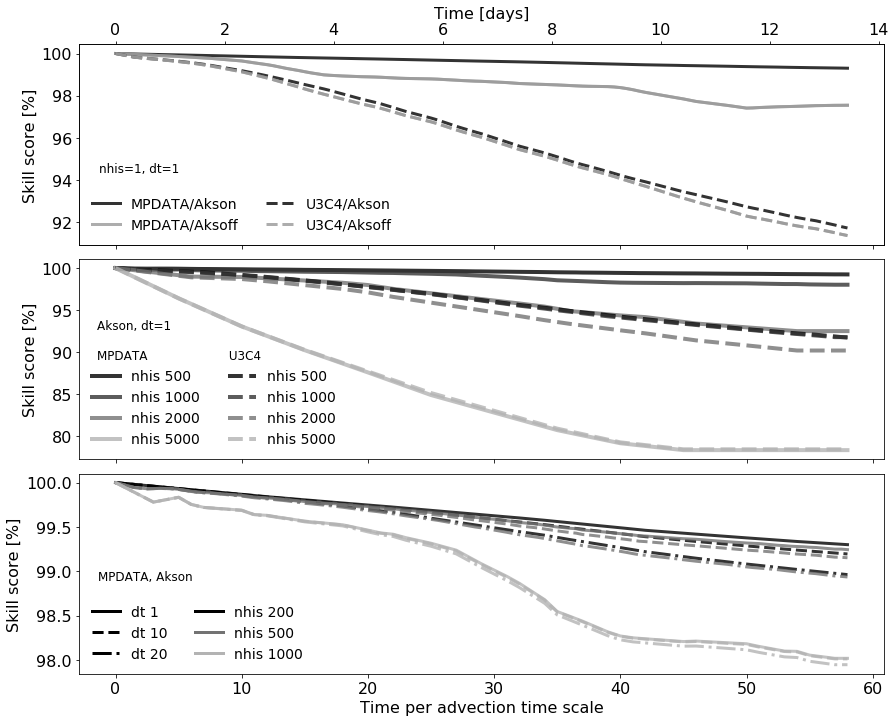

In [240]:
fig, axes = plt.subplots(3,1,figsize=(12,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(dfhis[iAksonMPDATA], colAkson, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(dfhis[iAksoffMPDATA], colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(dfhis[iAksonU3C4], colAkson, alpha=alpha, ls=lsU3C4, lw=3)
ax.plot(dfhis[iAksoffU3C4], colAksoff, alpha=alpha, ls=lsU3C4, lw=3)

ax.plot([], label="MPDATA/Akson", color=colAkson, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="MPDATA/Aksoff", color=colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="U3C4/Akson", color=colAkson, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="U3C4/Aksoff", color=colAksoff, alpha=alpha, ls=lsU3C4, lw=3)  



ax2 = ax.twiny()
# Ticks = ax.get_xticks()   
# ax2.set_xticks(Ticks)
ax2.set_xbound(ax.get_xbound())
# 
dayticks = np.arange(0,16,2)
Tticks = dayticks*86400/T  # normalize time by dynamic time scale
ax2.set_xticks(Tticks)
ax2.set_xticklabels(dayticks)
ax2.set_xlabel('Time [days]', fontsize=fsb)



# demonstrate overall spread of nhis for dt=1
ax = axes[1]
for col, label, color, ls in zip(colsnhis, labelsnhis, colorsnhis, lsnhis):#, colstc, colstls):
    ax.plot(dfhis[col], label=label, color=color, alpha=alpha, lw=4, ls=ls)
# ax.legend(title=, ncol=2, fontsize=fsm, framealpha=0, title_fontsize=fsm)


# demonstrate spread of dt for a few important nhis
ax = axes[2]

for col, c, ls, label in zip(colst, colorst, lst, labelst):
    ax.plot(dfhis[col], color=c, alpha=alpha, ls=ls, lw=3)
for ls, dt in zip(lss, dts):
    ax.plot([], label="dt %i" % dt, color='k', lw=3, ls=ls)
for c, nhis in zip(colors, nhist):
    ax.plot([], label="nhis %i" % nhis, color=c, lw=3)


ax.set_xlabel('Time per advection time scale', fontsize=16)

fig.tight_layout()

for ax,legendtitle in zip(axes.flat,legendtitles):
    ax.tick_params(labelsize=16)
    ax.legend(title=legendtitle, title_fontsize=fss, fontsize=fsm, ncol=2, framealpha=0)
    ax.set_ylabel('Skill score [%]', fontsize=16)
ax2.tick_params(labelsize=16)

fig.savefig('figures/ss.pdf', bbox_inches='tight')

The best performance comes from the MPDATA tracer advection schemes and forcing realistic Aks values from the online case. Using MPDATA without forcing realistic Aks values (using instead a constant value, whose value was found to be unimportant) is still better than using the U3/C4 tracer advection schemes. 

The importance of nhis is low as nhis increases until 200. As nhis increases beyond 200, there is a noticeable decrease in skill score with nhis=500, though performance is reasonably high still, but as nhis increases beyond 500, performance decreases drastically.

For nhis equal to 200 or less, the offline forcing time step is more important than the nhis value. For example, forcing the offline simulation with nhis=20 and dt=20 performs worse than forcing with nhis=200 and dt=10. So, in our case there is no reason to save output more frequently than nhis=200.



In [241]:
fname = 'output_ss/dfhis_persist.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')
# fname = 'output_ss/dfavg_persist.csv'
# dfavg = pd.read_csv(fname, index_col='ocean_time')

dfhis['days'] = dfhis.index
dfhis.index = dfhis.index*86400/T  # normalize time by dynamic time scale

In [242]:
alpha=0.8
whichadvects = ['MPDATA', 'U3C4']
cols = [col for col in dfhis.columns if 'dt50' not in col]

# Tracer advection schemes and Aks forcing or not
iMPDATA = [col for col in cols if 'MPDATA' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colMPDATA = 'k'; lsMPDATA = '-'
iU3C4 = [col for col in cols if 'U3C4' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colU3C4 = '0.6'; lsU3C4 = '--'

iAksonMPDATA = [col for col in iMPDATA if 'Akson' in col]
lsAkson = '-'; colAkson = 'k'
iAksoffMPDATA = [col for col in iMPDATA if 'Aksoff' in col]
lsAksoff = '-.'; colAksoff = '0.6'
iAksonU3C4 = [col for col in iU3C4 if 'Akson' in col]
iAksoffU3C4 = [col for col in iU3C4 if 'Aksoff' in col]


# Tracer advection and nhis variations
colors = ['0.0', '0.2', '0.45', '0.7']
lss = ['-', '--', '-.', ':']
colsnhis = []
colorsnhis = []
labelsnhis = []
lsnhis = []
nhist = [500,1000,2000,5000]  # everything lower than 200 is indistinguishable from 200
for whichadvect,ls in zip(whichadvects,[lsMPDATA,lsU3C4]):
    for (i, nhis), color in zip(enumerate(nhist), colors):
        colsnhis.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt1' in col
                      and not 'dt10' in col and 'Akson' in col and whichadvect in col])
        labelsnhis.append('nhis %i' % nhis)
        colorsnhis.append(color)
        lsnhis.append(ls)
        
        


colors = ['0.0', '0.45', '0.7']
colst = []
colorst = []  # colors to go with columns
lst = []  # linestyles to go with columns
labelst = []
nhist = [200,500,1000]  # everything lower than 200 is indistinguishable from 200
dts = [1, 10, 20]  # dt=2 indistinguishable from dt=1

for (i, nhis), color in zip(enumerate(nhist), colors):
    for dt, ls in zip(dts, lss):
        if dt>=50 or dt>nhis:
            continue
        if nhis==50 and dt==20:
            continue
        colst.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt%i' % dt in col
                      and not 'dt%i' % (dt*10) in col and 'MPDATA' in col and 'Akson' in col])
        colorst.append(color)
        lst.append(ls)
        labelst.append('nhis %i/dt %i' % (nhis,dt))

legendtitles = ['nhis=1, dt=1                                              \n',
                'Akson, dt=1\n\nMPDATA                 U3C4                  ',
               'MPDATA, Akson                       \n']


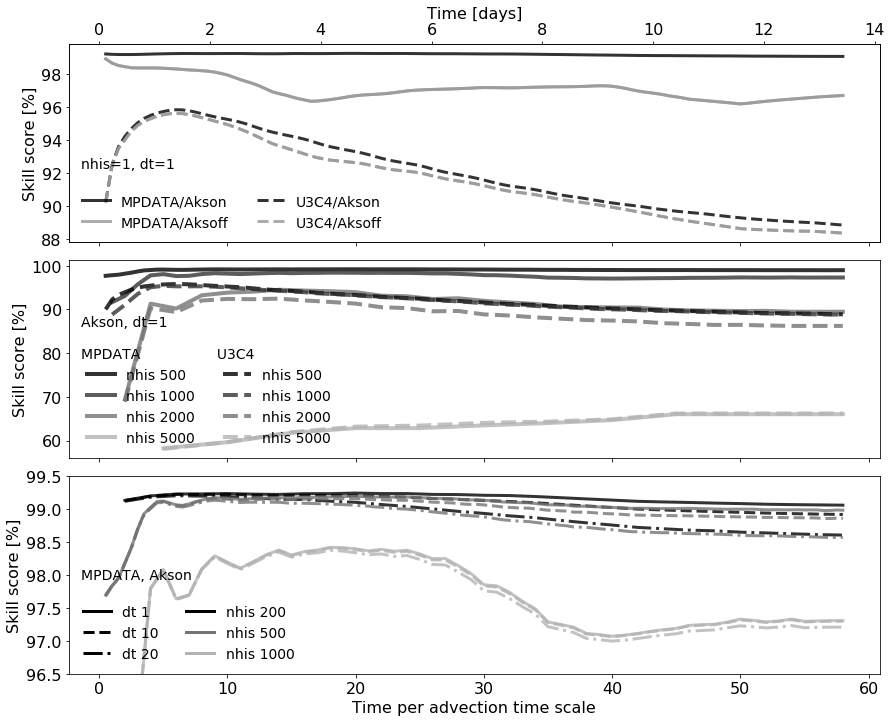

In [218]:
fig, axes = plt.subplots(3,1,figsize=(12,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(dfhis[iAksonMPDATA], colAkson, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(dfhis[iAksoffMPDATA], colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(dfhis[iAksonU3C4], colAkson, alpha=alpha, ls=lsU3C4, lw=3)
ax.plot(dfhis[iAksoffU3C4], colAksoff, alpha=alpha, ls=lsU3C4, lw=3)

ax.plot([], label="MPDATA/Akson", color=colAkson, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="MPDATA/Aksoff", color=colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="U3C4/Akson", color=colAkson, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="U3C4/Aksoff", color=colAksoff, alpha=alpha, ls=lsU3C4, lw=3)  



ax2 = ax.twiny()
# Ticks = ax.get_xticks()   
# ax2.set_xticks(Ticks)
ax2.set_xbound(ax.get_xbound())
# 
dayticks = np.arange(0,16,2)
Tticks = dayticks*86400/T  # normalize time by dynamic time scale
ax2.set_xticks(Tticks)
ax2.set_xticklabels(dayticks)
ax2.set_xlabel('Time [days]', fontsize=fsb)



# demonstrate overall spread of nhis for dt=1
ax = axes[1]
for col, label, color, ls in zip(colsnhis, labelsnhis, colorsnhis, lsnhis):#, colstc, colstls):
    ax.plot(dfhis[col], label=label, color=color, alpha=alpha, lw=4, ls=ls)
# ax.legend(title=, ncol=2, fontsize=fsm, framealpha=0, title_fontsize=fsm)


# demonstrate spread of dt for a few important nhis
ax = axes[2]

for col, c, ls, label in zip(colst, colorst, lst, labelst):
    ax.plot(dfhis[col], color=c, alpha=alpha, ls=ls, lw=3)
for ls, dt in zip(lss, dts):
    ax.plot([], label="dt %i" % dt, color='k', lw=3, ls=ls)
for c, nhis in zip(colors, nhist):
    ax.plot([], label="nhis %i" % nhis, color=c, lw=3)
ax.set_ylim(96.5,99.5)


ax.set_xlabel('Time per advection time scale', fontsize=16)

fig.tight_layout()

for ax,legendtitle in zip(axes.flat,legendtitles):
    ax.tick_params(labelsize=16)
    ax.legend(title=legendtitle, title_fontsize=fsm, fontsize=fsm, ncol=2, framealpha=0, loc='lower left')
    ax.set_ylabel('Skill score [%]', fontsize=16)
ax2.tick_params(labelsize=16)



# Demonstrate other issues

* Plot showing several smaller results:
 * Plot persistence skill score for one example case
 * his vs avg file forcing
 * single vs double precision

Use persistence setup from immediately above.

## his vs avg

In [219]:
fname = 'output_ss/dfhis.csv'
dfhis2 = pd.read_csv(fname, index_col='ocean_time')
fname = 'output_ss/dfavg.csv'
dfavg2 = pd.read_csv(fname, index_col='ocean_time')

dfhis2['days'] = dfhis2.index
dfhis2.index = dfhis2.index*86400/T  # normalize time by dynamic time scale

dfavg2['days'] = dfavg2.index
dfavg2.index = dfavg2.index*86400/T  # normalize time by dynamic time scale

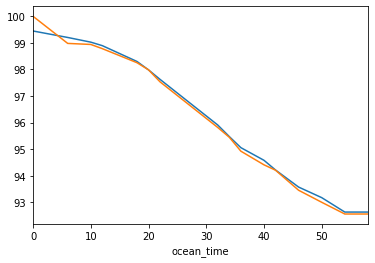

In [220]:
ax = dfavg2['MPDATA_Akson_avg_nhis2000_dt20'].plot()
dfhis2['MPDATA_Akson_his_nhis2000_dt20'].plot(ax=ax)

## Double vs single precision

In [221]:
loc = '%s/output_ss/MPDATA/nhis500/oil_03_his.nc' % baseon
dson2 = xr.open_dataset(loc, decode_times=False, chunks=chunks)

loc = '%s/output_ss/MPDATA/nhis500/oil_03_his_single.nc' % baseon
dson1 = xr.open_dataset(loc, decode_times=False, chunks=chunks)

loc = '%s/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt1_single.nc' % baseoff
dsoffdt1 = xr.open_dataset(loc, decode_times=False, chunks=chunks)

loc = '%s/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt1.nc' % baseoff
dsoffdt1d = xr.open_dataset(loc, decode_times=False, chunks=chunks)

loc = '%s/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt10_single.nc' % baseoff
dsoffdt10 = xr.open_dataset(loc, decode_times=False, chunks=chunks)

loc = '%s/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt20_single.nc' % baseoff
dsoffdt20 = xr.open_dataset(loc, decode_times=False, chunks=chunks)


### Skill score, single vs double precision

The single precision offline nhis500 simulations with 3 different dt values are essentially the same as each other for skill score (to 1e-4). 
The skill score for the double precision offline case (nhis500, dt1, double precision) is much higher than the same with single precision: final skill score after 13.5 days of 98% vs 91%.

In [222]:
ds = dson1
ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn
dyeon1 = (ds['dye_01']*dx*dy*dz)
denomon1 = np.sqrt(((dyeon1)**2).mean(('s_rho','eta_rho', 'xi_rho')))


ds = dson2
ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn
dyeon2 = (ds['dye_01']*dx*dy*dz)
denomon2 = np.sqrt(((dyeon2)**2).mean(('s_rho','eta_rho', 'xi_rho')))

# t = (denomon1.ocean_time - denomon1.ocean_time[0])/86400
# dfhis.index = dfhis.index*86400/T  # normalize time by dynamic time scale

98.22703140716798
91.18748053406925


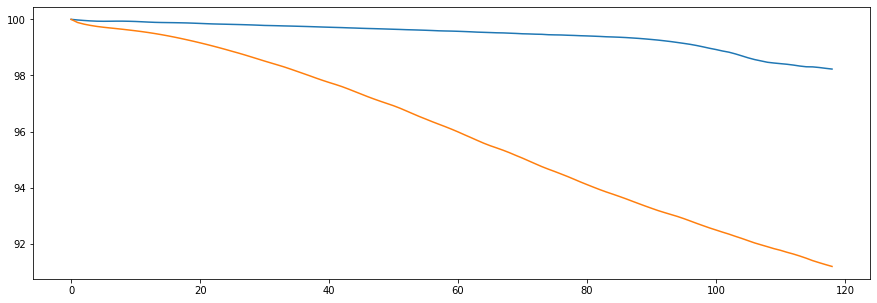

In [223]:
# compare skill score
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# compare conservation
dss = [dsoffdt1d, dsoffdt1, dsoffdt10, dsoffdt20]
# dss = [dsoffdt1, dsoffdt10, dsoffdt20]

dfpre = pd.DataFrame(index=ds.sel(ocean_time=slice(0,tend)).ocean_time)

# for ds in dss:
ds = dsoffdt1d
# ds = dss[0]

ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn
dye = (ds['dye_01']*dx*dy*dz)
num = np.sqrt(((dye - dyeon1)**2).mean(('s_rho','eta_rho', 'xi_rho')))

ss = (1-num/denomon1)*100
ax.plot(ss)
print(ss[-1].values)

dfpre['double'] = ss


ds = dsoffdt1
# ds = dss[0]

ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn
dye = (ds['dye_01']*dx*dy*dz)
num = np.sqrt(((dye - dyeon1)**2).mean(('s_rho','eta_rho', 'xi_rho')))

ss = (1-num/denomon1)*100
ax.plot(ss)
print(ss[-1].values)

dfpre['single'] = ss


In [224]:
t = (ds.ocean_time - ds.ocean_time[0])/T
dfpre.index = t
dfpre

,double,single
ocean_time,,
0.0,100.000000,100.000000
0.5,99.977770,99.888274
1.0,99.959910,99.828913
1.5,99.944570,99.784112
2.0,99.934431,99.747365
...,...,...
57.0,98.308929,91.480719
57.5,98.304916,91.394650
58.0,98.282804,91.322345


### Tracer conservation, single vs double precision

For online cases and tracer conservation, single and double precision are the same.

Online and dsoffdt1 are different.

Tracer conservation is also different, like skill score.

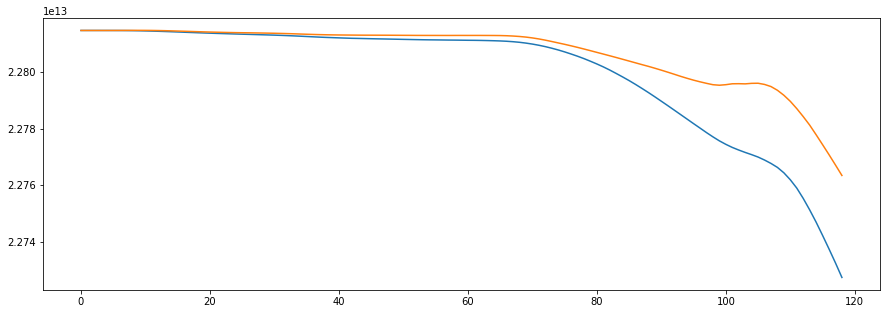

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# compare conservation
dss = [dsoffdt1d, dsoffdt1]#, dsoffdt10, dsoffdt20]

for ds in dss:
# ds = dss[0]

    ds = add_depths(ds)
    ds, grid = setup_grid(ds)  
    dz = grid.diff(ds.z_w, 's')
    dx = 1/ds.pm
    dy = 1/ds.pn
    dye = (ds['dye_01']*dx*dy*dz)
    dyesum = dye.sum(('s_rho', 'eta_rho', 'xi_rho'))

    ax.plot(dyesum)

## Forcing on and offline with different advection schemes


Plot together:

* online MPDATA/Akson/his/nhis500/oil_off_his.nc --> offline MPDATA/Akson/his/nhis500/oil_off_his_dt20.nc
* online MPDATA/Akson/his/nhis500/oil_off_his.nc --> offline U3C4/Akson/his/nhis500/oil_off_his_dt20B.nc
* online U3C4/Akson/his/nhis500/oil_off_his.nc --> offline U3C4/Akson/his/nhis500/oil_off_his_dt20.nc
* online U3C4/Akson/his/nhis500/oil_off_his.nc --> offline MPDATA/Akson/his/nhis500/oil_off_his_dt20B.nc



In [11]:
loc = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_his.nc'
dsonM = xr.open_dataset(loc, decode_times=False, chunks=chunks)

loc = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his.nc'
dsonU = xr.open_dataset(loc, decode_times=False, chunks=chunks)


In [14]:
dsonU.attrs['CPP_options']

'oil_03, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_SPFLUX, ASSUMED_SHAPE, AVERAGES, !BOUNDARY_A BULK_FLUXES, !COLLECT_ALL..., CURVGRID, DJ_GRADPS, DOUBLE_PRECISION, FLOATS, FLOAT_VWALK, GLS_MIXING, KANTHA_CLAYSON, LONGWAVE_OUT, MASKING, MIX_S_UV, MPI, NONLINEAR, NONLIN_EOS, N2S2_HORAVG, OUT_DOUBLE, POWER_LAW, PROFILE, K_GSCHEME, REDUCE_ALLGATHER, RI_SPLINES, !RST_SINGLE, SALINITY, SOLAR_SOURCE, SOLVE3D, SPLINES_VDIFF, SPLINES_VVISC, T_PASSIVE, TS_MPDATA, UV_ADV, UV_COR, UV_U3HADVECTION, UV_C4VADVECTION, UV_QDRAG, UV_VIS2, VAR_RHO_2D, !VWALK_FORWARD'

In [6]:
(dsonM.dye_01-dsonU.dye_01).sum().values

array(0.)

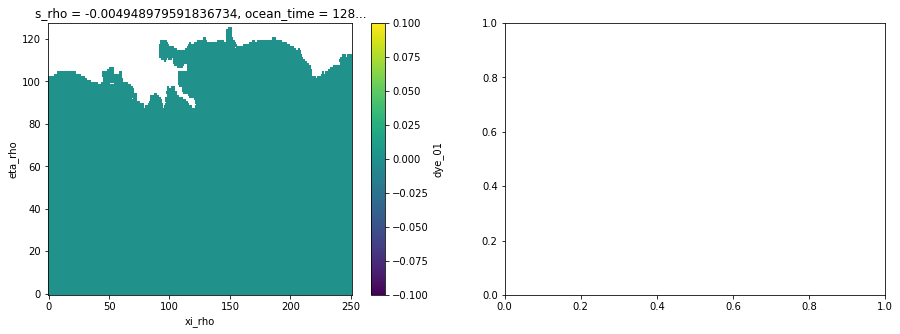

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
d1 = dsonM.dye_01.isel(ocean_time=-10, s_rho=-1)
d2 = dsonU.dye_01.isel(ocean_time=-10, s_rho=-1)

(d1-d2).plot(ax=axes[0])

In [5]:
fname = 'output_ss/dfhis.csv'
dfhis3 = pd.read_csv(fname, index_col='ocean_time')
dfhis3

,U3C4_Akson_his_nhis1_dt1,U3C4_Aksoff_Aksbak6_his_nhis1_dt1,U3C4_Aksoff_Aksbak3_his_nhis1_dt1,U3C4_Akson_his_nhis2_dt1,U3C4_Aksoff_Aksbak6_his_nhis2_dt1,U3C4_Aksoff_Aksbak3_his_nhis2_dt1,U3C4_Akson_his_nhis2_dt2,U3C4_Aksoff_Aksbak6_his_nhis2_dt2,U3C4_Aksoff_Aksbak3_his_nhis2_dt2,U3C4_Akson_his_nhis5_dt1,...,MPDATA_Akson_his_nhis5000_dt1,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt1,MPDATA_Akson_his_nhis5000_dt2,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt2,MPDATA_Akson_his_nhis5000_dt5,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt5,MPDATA_Akson_his_nhis5000_dt10,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt10,MPDATA_Akson_his_nhis5000_dt20,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt20
ocean_time,,,,,,,,,,,,,,,,,,,,,
0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.115741,99.942264,99.941331,99.941331,99.942264,99.941331,99.941331,99.942264,99.941331,99.941331,99.942264,...,99.640272,99.639771,99.640276,99.639775,99.640287,99.639785,99.640304,99.639802,99.640336,99.639834
0.231481,99.884528,99.882661,99.882661,99.884528,99.882661,99.882661,99.884527,99.882661,99.882661,99.884528,...,99.280545,99.279543,99.280552,99.279550,99.280573,99.279570,99.280607,99.279604,99.280672,99.279668
0.347222,99.826791,99.823992,99.823992,99.826791,99.823992,99.823992,99.826791,99.823992,99.823992,99.826791,...,98.920817,98.919314,98.920828,98.919324,98.920860,98.919355,98.920911,98.919406,98.921009,98.919502
0.462963,99.797989,99.793182,99.793182,99.797989,99.793182,99.793182,99.797989,99.793182,99.793182,99.797989,...,98.561090,98.559085,98.561104,98.559099,98.561146,98.559141,98.561214,98.559208,98.561345,98.559336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12.962963,91.987934,91.613002,91.613002,91.987934,91.613002,91.613002,91.987928,91.613002,91.613002,91.987934,...,78.337789,78.169591,78.342970,78.174896,78.358286,78.190454,78.382800,78.215812,78.429556,78.263893
13.078704,91.920986,91.550346,91.550346,91.920987,91.550346,91.550346,91.920981,91.550347,91.550347,91.920986,...,78.337789,78.169591,78.342970,78.174896,78.358286,78.190454,78.382800,78.215812,78.429556,78.263893
13.194444,91.854039,91.487691,91.487691,91.854040,91.487691,91.487691,91.854033,91.487691,91.487691,91.854037,...,78.337789,78.169591,78.342970,78.174896,78.358286,78.190454,78.382800,78.215812,78.429556,78.263893


In [6]:
loc = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis500/oil_03_his'
dsonM = xr.open_zarr(loc, decode_times=False, chunks=chunks)
dsonM['ocean_time'] = (dsonM.ocean_time - dsonM.ocean_time[0])/86400

ds = dsonM
denomonM = np.sqrt(((ds['dye_01'].sel(ocean_time=slice(0,tend)))**2).mean(('s_rho','eta_rho', 'xi_rho')))
# denomonM = np.sqrt(((ds['dye_01'].isel(eta_rho=slice(iy[0],iy[1]), 
#                            xi_rho=slice(ix[0],ix[1])))**2).mean(('s_rho','eta_rho', 'xi_rho')))

loc = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt20B.nc'
dsoffMU = xr.open_dataset(loc, decode_times=False, chunks=chunks)
dsoffMU['ocean_time'] = (dsoffMU.ocean_time - dsoffMU.ocean_time[0])/86400


ds = dsoffMU
ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn
dye = (ds['dye_01']*dx*dy*dz).isel(eta_rho=slice(iy[0],iy[1]), 
                           xi_rho=slice(ix[0],ix[1])).sel(ocean_time=slice(0,tend))
numMU = np.sqrt(((dye - dsonM['dye_01'])**2).mean(('s_rho','eta_rho', 'xi_rho')))


In [7]:
loc = '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his'
dsonU = xr.open_zarr(loc, decode_times=False, chunks=chunks)
dsonU['ocean_time'] = (dsonU.ocean_time - dsonU.ocean_time[0])/86400

ds = dsonU
denomonU = np.sqrt(((ds['dye_01'].sel(ocean_time=slice(0,tend)))**2).mean(('s_rho','eta_rho', 'xi_rho')))


loc = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt20B.nc'
dsoffUM = xr.open_dataset(loc, decode_times=False, chunks=chunks)
dsoffUM['ocean_time'] = (dsoffUM.ocean_time - dsoffUM.ocean_time[0])/86400


ds = dsoffUM
ds = add_depths(ds)
ds, grid = setup_grid(ds)  
dz = grid.diff(ds.z_w, 's')
dx = 1/ds.pm
dy = 1/ds.pn
# dye = (ds['dye_01']*dx*dy*dz)
dye = (ds['dye_01']*dx*dy*dz).isel(eta_rho=slice(iy[0],iy[1]), 
                           xi_rho=slice(ix[0],ix[1])).sel(ocean_time=slice(0,tend))
numUM = np.sqrt(((dye - dsonU['dye_01'])**2).mean(('s_rho','eta_rho', 'xi_rho')))


In [8]:
keyMM = 'MPDATA_Akson_his_nhis500_dt20'
keyUU = 'U3C4_Akson_his_nhis500_dt20'

In [9]:
dfmix = dfhis3[[keyMM,keyUU]]
dfmix

,MPDATA_Akson_his_nhis500_dt20,U3C4_Akson_his_nhis500_dt20
ocean_time,,
0.000000,100.000000,100.000000
0.115741,99.981467,99.939941
0.231481,99.962935,99.879881
0.347222,99.944402,99.819822
0.462963,99.937580,99.791108
...,...,...
12.962963,98.964872,91.999489
13.078704,98.956183,91.932729
13.194444,98.947494,91.865969


In [10]:
keyMU = 'MPDATA_Akson_his_nhis500_dt20_U3C4'
keyUM = 'U3C4_Akson_his_nhis500_dt20_MPDATA'
dfmix[keyMU] = (100*(1-numMU/denomonM)).sel(ocean_time=slice(0,tend)).values
dfmix[keyUM] = (100*(1-numUM/denomonU)).sel(ocean_time=slice(0,tend)).values
dfmix

/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,MPDATA_Akson_his_nhis500_dt20,U3C4_Akson_his_nhis500_dt20,MPDATA_Akson_his_nhis500_dt20_U3C4,U3C4_Akson_his_nhis500_dt20_MPDATA
ocean_time,,,,
0.000000,100.000000,100.000000,100.000000,100.000000
0.115741,99.981467,99.939941,99.903739,99.977621
0.231481,99.962935,99.879881,99.856397,99.959771
0.347222,99.944402,99.819822,99.819822,99.944402
0.462963,99.937580,99.791108,99.788158,99.934179
...,...,...,...,...
12.962963,98.964872,91.999489,92.004204,98.965321
13.078704,98.956183,91.932729,91.936300,98.956083
13.194444,98.947494,91.865969,91.865969,98.947494


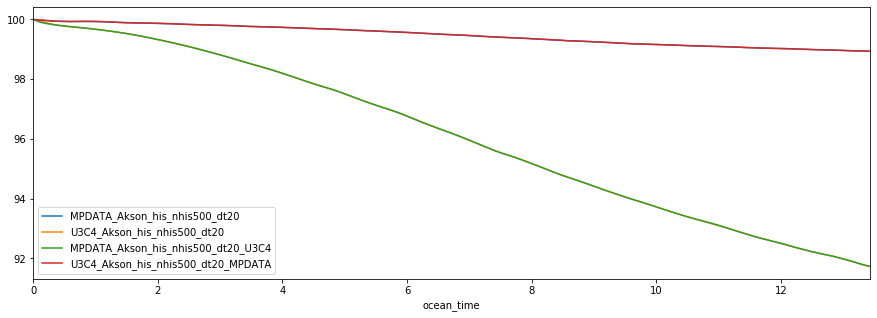

In [11]:
dfmix.plot(figsize=(15,5))

### How do online MPDATA and U3C4 compare?

In [12]:
denomon = np.sqrt(((dsonM['dye_01'].sel(ocean_time=slice(0,tend)))**2).mean(('s_rho','eta_rho', 'xi_rho')))
numon = np.sqrt(((dsonM['dye_01'] - dsonU['dye_01'])**2).mean(('s_rho','eta_rho', 'xi_rho')))

keyon = 'MPDATA_U3C4_nhis500'
dfmix[keyon] = (100*(1-numon/denomon)).sel(ocean_time=slice(0,tend)).values


/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
dfmix

,MPDATA_Akson_his_nhis500_dt20,U3C4_Akson_his_nhis500_dt20,MPDATA_Akson_his_nhis500_dt20_U3C4,U3C4_Akson_his_nhis500_dt20_MPDATA,MPDATA_U3C4_nhis500
ocean_time,,,,,
0.000000,100.000000,100.000000,100.000000,100.000000,100.0
0.115741,99.981467,99.939941,99.903739,99.977621,100.0
0.231481,99.962935,99.879881,99.856397,99.959771,100.0
0.347222,99.944402,99.819822,99.819822,99.944402,100.0
0.462963,99.937580,99.791108,99.788158,99.934179,100.0
...,...,...,...,...,...
12.962963,98.964872,91.999489,92.004204,98.965321,100.0
13.078704,98.956183,91.932729,91.936300,98.956083,100.0
13.194444,98.947494,91.865969,91.865969,98.947494,100.0


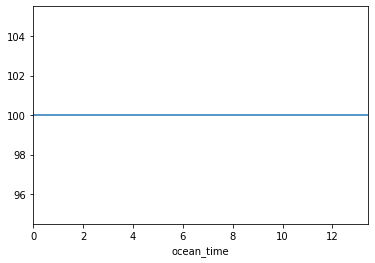

In [14]:
dfmix[keyon].plot()

In [245]:
legendtitles = ['nhis=1, dt=1                          \n',
                'nhis=200, dt=20, MPDATA, Akson\n',
               'Precision']


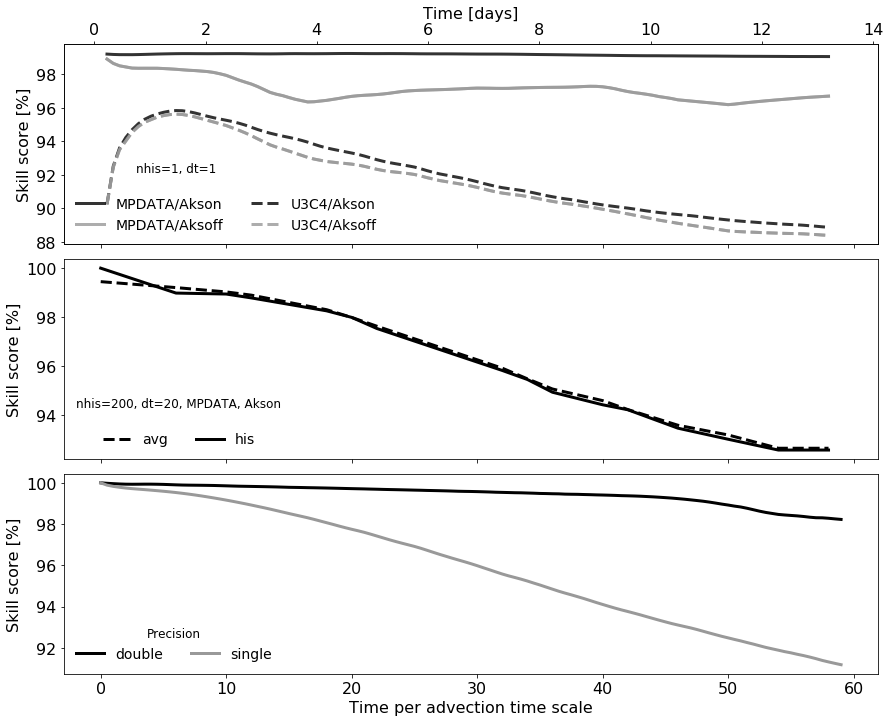

In [247]:
fig, axes = plt.subplots(3,1,figsize=(12,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(dfhis[iAksonMPDATA], colAkson, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(dfhis[iAksoffMPDATA], colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)
ax.plot(dfhis[iAksonU3C4], colAkson, alpha=alpha, ls=lsU3C4, lw=3)
ax.plot(dfhis[iAksoffU3C4], colAksoff, alpha=alpha, ls=lsU3C4, lw=3)

ax.plot([], label="MPDATA/Akson", color=colAkson, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="MPDATA/Aksoff", color=colAksoff, alpha=alpha, ls=lsMPDATA, lw=3)  
ax.plot([], label="U3C4/Akson", color=colAkson, alpha=alpha, ls=lsU3C4, lw=3)  
ax.plot([], label="U3C4/Aksoff", color=colAksoff, alpha=alpha, ls=lsU3C4, lw=3)  

ax2 = ax.twiny()
ax2.set_xbound(ax.get_xbound())
dayticks = np.arange(0,16,2)
Tticks = dayticks*86400/T  # normalize time by dynamic time scale
ax2.set_xticks(Tticks)
ax2.set_xticklabels(dayticks)
ax2.set_xlabel('Time [days]', fontsize=fsb)



ax = axes[1]
key = 'MPDATA_Akson_avg_nhis2000_dt20'
ax.plot(dfavg2[key], 'k', ls='--', label='avg', lw=3)
ax.plot(dfhis2[key.replace('avg','his')], 'k', ls='-', label='his', lw=3)




ax = axes[2]
ax.plot(dfpre['double'], color='k', label='double', lw=3)
ax.plot(dfpre['single'], color='0.6', label='single', lw=3)



ax.set_xlabel('Time per advection time scale', fontsize=16)

fig.tight_layout()

for ax,legendtitle in zip(axes.flat,legendtitles):
    ax.tick_params(labelsize=16)
    ax.legend(title=legendtitle, title_fontsize=fss, fontsize=fsm, ncol=2, framealpha=0, loc='lower left')
    ax.set_ylabel('Skill score [%]', fontsize=16)
ax2.tick_params(labelsize=16)

fig.savefig('figures/demon.pdf', bbox_inches='tight')

# Compare run time, storage, and skill score

* plot ss vs run time vs storage time as a 3d plot or line plot with contours
 * how to present storage normalized. As a function of number of grid nodes horizontally and vertically (since some variables are 3d and some 4d)
 * xaxis: time per time step per core, 
 * y axis: required storage normalized by horizontal and vertical number of nodes per time step, account for single vs double precision
 * z contour: skill score. Have Akson and Aksoff separate lines.
 * check on time required for MPDATA vs. U3C4.


Do this all on a per output or per time step (or combined?) basis?
Can treat skill score as line and approximate ss with time.

In [ ]:
# # double precision
# nhis=2
# Lm, Mm, N = 250, 126, 50
# num2d, num3d = 3, 4
# nbytes = 8  # double precision
# gbperts = (Lm*Mm*num2d + Lm*Mm*N*num3d)*nbytes/1e9
# ndays = 14
# dtbase = 20
# numts = 14*86400/(20*nhis)
# gbperts* (numts)

In [249]:
num2d = 3  # zeta, ubar, vbar
def calc_storage(LmMm, N, num3d, nbytes):#, nhis):
    '''Calculate amount of storage required for simulation choices.
    
    nhis: How often to save output, by multiples of online time steps.
    returns as GB
    
    '''
    return (LmMm*num2d + LmMm*N*num3d)*nbytes/1e9

In [250]:
fname = 'output_ss/dfhis.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')
cols = dfhis.columns
cols = [col for col in cols if 'MPDATA' in col]
dfhis[cols]

,MPDATA_Akson_his_nhis1_dt1,MPDATA_Aksoff_Aksbak6_his_nhis1_dt1,MPDATA_Aksoff_Aksbak3_his_nhis1_dt1,MPDATA_Akson_his_nhis2_dt1,MPDATA_Aksoff_Aksbak6_his_nhis2_dt1,MPDATA_Aksoff_Aksbak3_his_nhis2_dt1,MPDATA_Akson_his_nhis2_dt2,MPDATA_Aksoff_Aksbak6_his_nhis2_dt2,MPDATA_Aksoff_Aksbak3_his_nhis2_dt2,MPDATA_Akson_his_nhis5_dt1,...,MPDATA_Akson_his_nhis5000_dt1,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt1,MPDATA_Akson_his_nhis5000_dt2,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt2,MPDATA_Akson_his_nhis5000_dt5,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt5,MPDATA_Akson_his_nhis5000_dt10,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt10,MPDATA_Akson_his_nhis5000_dt20,MPDATA_Aksoff_Aksbak6_his_nhis5000_dt20
ocean_time,,,,,,,,,,,,,,,,,,,,,
0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.115741,99.992573,99.986550,99.986550,99.992573,99.986550,99.986550,99.992571,99.986548,99.986548,99.992573,...,99.640272,99.639771,99.640276,99.639775,99.640287,99.639785,99.640304,99.639802,99.640336,99.639834
0.231481,99.985145,99.973099,99.973099,99.985146,99.973099,99.973099,99.985142,99.973097,99.973097,99.985146,...,99.280545,99.279543,99.280552,99.279550,99.280573,99.279570,99.280607,99.279604,99.280672,99.279668
0.347222,99.977718,99.959649,99.959649,99.977718,99.959649,99.959649,99.977713,99.959645,99.959645,99.977718,...,98.920817,98.919314,98.920828,98.919324,98.920860,98.919355,98.920911,98.919406,98.921009,98.919502
0.462963,99.970924,99.944467,99.944467,99.970924,99.944467,99.944467,99.970918,99.944464,99.944464,99.970924,...,98.561090,98.559085,98.561104,98.559099,98.561146,98.559141,98.561214,98.559208,98.561345,98.559336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12.962963,99.319600,97.528123,97.528123,99.319610,97.528119,97.528119,99.318113,97.532065,97.532065,99.319630,...,78.337789,78.169591,78.342970,78.174896,78.358286,78.190454,78.382800,78.215812,78.429556,78.263893
13.078704,99.315346,97.533068,97.533068,99.315355,97.533062,97.533062,99.313792,97.537042,97.537042,99.315381,...,78.337789,78.169591,78.342970,78.174896,78.358286,78.190454,78.382800,78.215812,78.429556,78.263893
13.194444,99.311093,97.538013,97.538013,99.311101,97.538006,97.538006,99.309471,97.542019,97.542019,99.311131,...,78.337789,78.169591,78.342970,78.174896,78.358286,78.190454,78.382800,78.215812,78.429556,78.263893


In [251]:
# wall clock times
# nums = [9.5*3600, 5.5*3600, 3*3600, 2.5*3600, 1.5*3600, 1.25*3600, 70*60, 65*60, 65*60, 1.25*3600, 1*3600, 1*3600]
# nums = [9.5hr, 5.5hr, 3hr, 2.5hr, 1.5hr, 1.25hr, 70min, 65min, 65min, 1.25hr, 1hr, 1h]
# computational times, seconds. Online runs used 84 cores
nums = [2825931.469, 1737185.114, 839068.508, 793547.343, 458570.268, 386043.619,
        360110.516, 344449.453, 338551.199, 391777.237, 336277.400, 339932.064]
nhiss = [1,2,5,10,20,50,100,200,500,1000,2000,5000]
ton = pd.DataFrame(index=nhiss, data={'time [s]': nums})

# ton['time [s/core]'] = ton['time [s]']/84
ndays = 1
dtbase = 20
ton['noutputs'] = ndays*86400/(dtbase*ton.index)
# ton['time [s/core/output]'] = ton['time [s/core]']/ton['noutputs']
ton['time [s/day]'] = ton['time [s]']*ton['noutputs']
ton

,time [s],noutputs,time [s/day]
1,2825931.469,4320.000,1.220802e+10
2,1737185.114,2160.000,3.752320e+09
5,839068.508,864.000,7.249552e+08
10,793547.343,432.000,3.428125e+08
20,458570.268,216.000,9.905118e+07
50,386043.619,86.400,3.335417e+07
100,360110.516,43.200,1.555677e+07
200,344449.453,21.600,7.440108e+06
500,338551.199,8.640,2.925082e+06
1000,391777.237,4.320,1.692478e+06


In [252]:
nhist = [1, 2, 2, 5, 5, 10, 10, 10, 10, 20, 20, 20, 20, 20, 50, 50, 50, 50, 100, 100, 100, 100, 100,
        200, 200, 200, 200, 200, 500, 500, 500, 500, 500, 1000, 1000, 1000, 1000, 1000,
        2000, 2000, 2000, 2000, 2000, 5000, 5000, 5000, 5000, 5000]
dtt = [1, 1, 2, 1, 5, 1, 2, 5, 10, 1, 2, 5, 10, 20, 1, 2, 5, 10, 1, 2, 5, 10, 20, 
       1, 2, 5, 10, 20, 1, 2, 5, 10, 20, 1, 2, 5, 10, 20, 
       1, 2, 5, 10, 20, 1, 2, 5, 10, 20]
# wall time
# nums = [5.5hr, 4hr, 3.5hr, 2.75hr, 1.25hr, 2.5hr, 1.25hr, 0.75hr, 0.5hr, 2 hr, 1hr, 0.5hr, 20min,15min,2hr,1hr,30min,
#        15min,2hr,1hr,25min,15min,10min,2hr,1hr,20min,13min,7min,2hr,50min,20min,12min,6min,2hr,1hr,20min,10min,6min,
#         1.75hr,55min,20min,10min,6min,1.75hr,50min,20min,10min,4min]
# nums = [5.5*3600, 4*3600, 3.5*3600, 2.75*3600, 1.25*3600, 2.5*3600, 1.25*3600, 0.75*3600, 0.5*3600, 2 *3600, 1*3600, 0.5*3600, 20*60,15*60,2*3600,1*3600,30*60,
#        15*60,2*3600,1*3600,25*60,15*60,10*60,2*3600,1*3600,20*60,13*60,7*60,2*3600,50*60,20*60,12*60,6*60,2*3600,1*3600,20*60,10*60,6*60,
#         1.75*3600,55*60,20*60,10*60,6*60,1.75*3600,50*60,20*60,10*60,4*60]
# computational time, on 14 cores
nums = [268592.190,201302.901,170146.556,134096.913,60822.158,114804.795,65056.768,36503.187,24703.099,
        107019.050,57129.455,25036.339,16527.226,13363.202,100975.423,45581.358,21304.997,12956.135,
        99005.493,45231.540,19183.813,9962.031,5394.719,97590.946,43474.343,17592.488,10383.829,10366.869,
        96594.742,43892.781,17655.773,8193.363,10890.806,93792.759,46770.467,16727.102,9280.589,4973.816,
        82943.488,45104.087,17292.629,9212.880,4575.568,81901.533,40687.307,14961.534,8186.131,3440.105]
toff = pd.DataFrame(index=nhist, data={'dt': dtt, 'time [s]': nums})
# toff['time [s/core]'] = toff['time [s]']/14
toff['noutputs'] = ndays*86400/(toff['dt']*dtbase*toff.index)
# toff['time [s/core/output]'] = toff['time [s/core]']/toff['noutputs']
toff['time [s/day]'] = toff['time [s]']*toff['noutputs']
toff


,dt,time [s],noutputs,time [s/day]
1,1,268592.190,4320.0000,1.160318e+09
2,1,201302.901,2160.0000,4.348143e+08
2,2,170146.556,1080.0000,1.837583e+08
5,1,134096.913,864.0000,1.158597e+08
5,5,60822.158,172.8000,1.051007e+07
10,1,114804.795,432.0000,4.959567e+07
10,2,65056.768,216.0000,1.405226e+07
10,5,36503.187,86.4000,3.153875e+06
10,10,24703.099,43.2000,1.067174e+06
20,1,107019.050,216.0000,2.311611e+07


In [253]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10))

Lm, Mm, N = 250, 126, 50
nhiss = [1,2,5,10,20,50,100,200,500,1000,2000,5000]
dts = [1,2,5,10,20]
aksflags = ['Akson', 'Aksoff']
aks = 1e-6
clminput = 'his'
whichadvects = ['MPDATA']#,'U3C4']
precisions = ['double']#, 'single']
nbytess = [8]#,4]

# tfaks, sfaks, ssfaks, nfaks = [], [], [], []
tf, sf, ssf, nf, tonf = [], [], [], [], []
nhisf, dttf, aksf = [], [], []
for whichadvect in whichadvects:
    for i, nhis in enumerate(nhiss):
        dd = int(500/nhis)

        locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)

        # for each nhis, the possible time step dts to run is from 1 up to equal to clm
        dts = nhiss[:i+1]

        if nhis == 5:
            dts = [1]
        elif nhis == 50:
            dts = [1,2,5,10]

        # loop over sim time step
        for dt in dts:


            if dt >= 50:  # dt=100 creates instabilities and results are invalid
                continue

            # Aks forcing can be turned on or off
            for aksflag in aksflags:
                if aksflag == 'Akson':
                    name = '%s_%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,clminput,nhis,dt)
                    num3d = 4
                elif aksflag == 'Aksoff':
                    exp = int(abs(np.log10(aks)))
                    name = '%s_%s_Aksbak%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,exp,clminput,nhis,dt)
                    num3d = 3
    #             print(name)

                for nbytes, precision in zip(nbytess,precisions):

                    # Calculate storage per output (as a function of time)
                    S = calc_storage(Lm*Mm, N, num3d, nbytes)

                    # calculate time
    #                 noutputstotal = ndays*86400/(dtbase*nhis)
    #                 print(noutputstotal)
    #                 outputs = np.arange(0,noutputstotal)
    #                 print(outputs)
                    tf.append((toff[toff['dt']==dt].loc[nhis,'time [s/day]']))
#                     tf.append((ton.loc[nhis,'time [s/day]'] + toff[toff['dt']==dt].loc[nhis,'time [s/day]']))
    #                 print(t)
                    tonf.append((ton.loc[nhis,'time [s/day]']))
        
                    sf.append(S*ton.loc[nhis,'noutputs'])

                    # estimate skill score as a 1st order polynomial from the skill score results for this run
                    # as a function of time
                    ss = dfhis[name].iloc[-1]
                    ssf.append(ss)
                    nf.append(name)
                    nhisf.append(nhis)
                    dttf.append(dt)
                    aksf.append(aksflag)
#                     print(name, ss)


In [254]:
dtf = pd.DataFrame(data={'nhis': nhisf, 'dt': dttf, 't': tf, 'storage': sf, 'ss': ssf, 'Aks': aksf, 'ton': tonf})
dtf

,nhis,dt,t,storage,ss,Aks,ton
0,1,1,1.160318e+09,276.514560,99.301515,Akson,1.220802e+10
1,1,1,1.160318e+09,222.082560,97.542595,Aksoff,1.220802e+10
2,2,1,4.348143e+08,138.257280,99.301525,Akson,3.752320e+09
3,2,1,4.348143e+08,111.041280,97.542587,Aksoff,3.752320e+09
4,2,2,1.837583e+08,138.257280,99.299956,Akson,3.752320e+09
...,...,...,...,...,...,...,...
89,5000,5,2.585353e+03,0.044417,78.190454,Aksoff,2.937013e+05
90,5000,10,7.072817e+02,0.055303,78.382800,Akson,2.937013e+05
91,5000,10,7.072817e+02,0.044417,78.215812,Aksoff,2.937013e+05
92,5000,20,1.486125e+02,0.055303,78.429556,Akson,2.937013e+05


In [255]:
# from matplotlib import cm
# cmap = cmo.deep_r
# cmap = cm.get_cmap(cmap, 2)


import cmocean.tools
ncons = 8
cmap = cmo.thermal
rgb = cmap(np.linspace(0,1,ncons))
cmap = cmocean.tools.cmap(rgb, N=ncons)
cmap

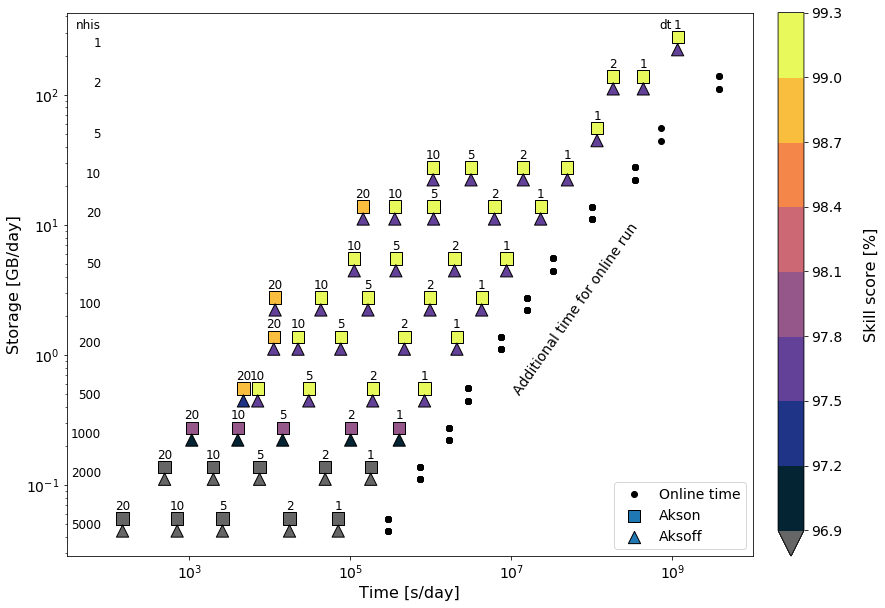

In [257]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# cmap = cmo.deep_r

fig, ax = plt.subplots(1,1,figsize=(15,10))

# https://matplotlib.org/examples/axes_grid/scatter_hist.html
# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
# divider = make_axes_locatable(ax)
# axbot = divider.append_axes("bottom", 1.2, pad=0.1, sharex=ax)

# # make some labels invisible
# plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
#          visible=False)


subon = dtf[dtf['Aks'] == 'Akson']
sub = dtf[dtf['Aks'] == 'Aksoff']
vmax = 99.3; vmin = 96.9  # to make even contour bounds
# vmin = dtf['ss'].min(); vmax = dtf['ss'].max()

# cmap = cmap(np.linspace(0,1,8))
# # set limits .5 outside true range
# mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
# #tell the colorbar to tick at integers
# cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

    
ax.scatter(subon['t'], subon['storage'], c=subon['ss'], s=ms, cmap=cmap, marker='s', 
           vmin=vmin, vmax=vmax, edgecolors='k', label='Akson')#, norm=colors.LogNorm())

mappable = ax.scatter(sub['t'], sub['storage'], c=sub['ss'], s=ms, cmap=cmap, marker='^', 
                      vmin=vmin, vmax=vmax, edgecolors='k', label='Aksoff')#, norm=colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')


ax.set_xlabel('Time [s/day]', fontsize=fsb)
ax.set_ylabel('Storage [GB/day]', fontsize=fsb)

cb = fig.colorbar(mappable, pad=0.03, ticks=np.linspace(vmin, vmax, ncons+1), extend='min', ax=ax)
mappable.cmap.set_under('0.4')
cb.set_label('\nSkill score [%]', fontsize=fsb)
cb.ax.tick_params(labelsize=fsm)

ax.tick_params(labelsize=fsm)

ax.set_xlim(30,1e10)

# Loop over rows when the nhis value changes create text annotations.
i = 0
loops = np.unique(subon[['storage','nhis']].values, axis=0)
for y, z in loops:
    i+=1
    if i==len(loops):
        text = ax.text(80, y*1.1, 'nhis', ha="right", va="bottom", color="k", fontsize=fss)
    text = ax.text(80, y, '%i'%z, ha="right", va="top", color="k", fontsize=fss)
    
loops = subon[['t','storage','dt']].values
i =0 
for x, y, z in loops:
    if i==0:
        text = ax.text(x*0.7, y*1.1, 'dt', ha="center", va="bottom", color="k", fontsize=fss)
        i+=1
    text = ax.text(x, y*1.1, '%i'%z, ha="center", va="bottom", color="k", fontsize=fss)
    

ax.loglog(dtf['ton'], dtf['storage'], 'k', marker='o', ls='', label='Online time')
    
ax.legend(loc='lower right', fontsize=fsm)


ax.text(1e7, 0.5, 'Additional time for online run', rotation=55, fontsize=fsm)

# axbot.loglog(ton.loc[:,'time [s/day]'], ton.index, marker='o')
# axbot.invert_yaxis()

fig.savefig('figures/sum_low.png', bbox_inches='tight', dpi=100)
fig.savefig('figures/sum.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/sum.pdf', bbox_inches='tight')

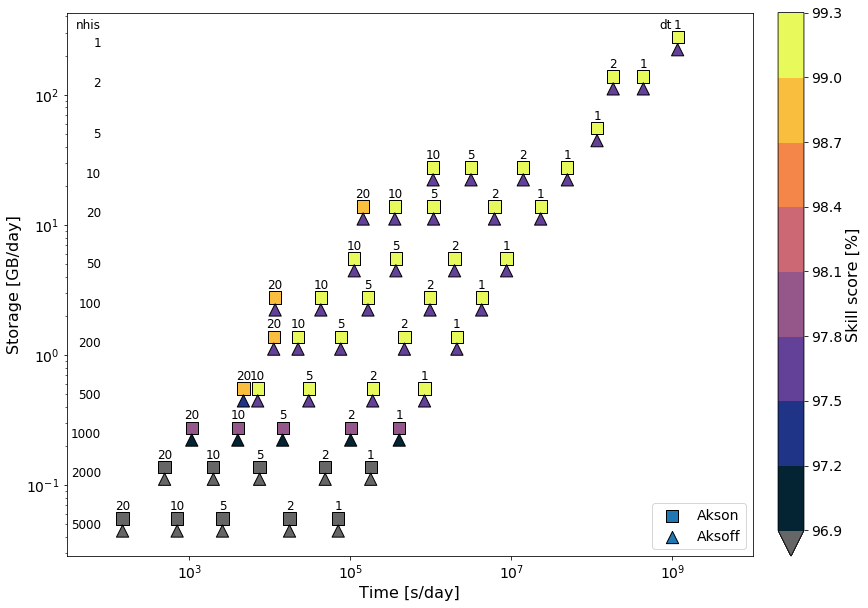

In [183]:
# cmap = cmo.deep_r
fss = 12
fsm = 14
fsb = 16
ms = 150

fig, ax = plt.subplots(1,1,figsize=(15,10))

subon = dtf[dtf['Aks'] == 'Akson']
sub = dtf[dtf['Aks'] == 'Aksoff']
vmax = 99.3; vmin = 96.9  # to make even contour bounds
# vmin = dtf['ss'].min(); vmax = dtf['ss'].max()

# cmap = cmap(np.linspace(0,1,8))
# # set limits .5 outside true range
# mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
# #tell the colorbar to tick at integers
# cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

    
ax.scatter(subon['t'], subon['storage'], c=subon['ss'], s=ms, cmap=cmap, marker='s', 
           vmin=vmin, vmax=vmax, edgecolors='k', label='Akson')#, norm=colors.LogNorm())

mappable = ax.scatter(sub['t'], sub['storage'], c=sub['ss'], s=ms, cmap=cmap, marker='^', 
                      vmin=vmin, vmax=vmax, edgecolors='k', label='Aksoff')#, norm=colors.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Time [s/day]', fontsize=fsb)
ax.set_ylabel('Storage [GB/day]', fontsize=fsb)

cb = fig.colorbar(mappable, pad=0.03, ticks=np.linspace(vmin, vmax, ncons+1), extend='min')
mappable.cmap.set_under('0.4')
cb.set_label('Skill score [%]', fontsize=fsb)
cb.ax.tick_params(labelsize=fsm)

ax.tick_params(labelsize=fsm)

ax.set_xlim(30,1e10)

# Loop over rows when the nhis value changes create text annotations.
i = 0
loops = np.unique(subon[['storage','nhis']].values, axis=0)
for y, z in loops:
    i+=1
    if i==len(loops):
        text = ax.text(80, y*1.1, 'nhis', ha="right", va="bottom", color="k", fontsize=fss)
    text = ax.text(80, y, '%i'%z, ha="right", va="top", color="k", fontsize=fss)
    
loops = subon[['t','storage','dt']].values
i =0 
for x, y, z in loops:
    if i==0:
        text = ax.text(x*0.7, y*1.1, 'dt', ha="center", va="bottom", color="k", fontsize=fss)
        i+=1
    text = ax.text(x, y*1.1, '%i'%z, ha="center", va="bottom", color="k", fontsize=fss)
    
    
#     plt.loglog(ton.loc[:,'time [s/day]'], ton.index, marker='o')
    
ax.legend(loc='lower right', fontsize=fsm)

Note here that time includes both the online and offline simulation time, so as more offline simulations are run, this time would relatively decrease per simulation. The overall time was for the 14 days simulations.

Storage has been multiplied out for the number of outputs required for 14 days. Give number of grid cells, etc.

# Tracer conservation

 * online one of the runs MPDATA and U3C4, then compare with highest offline (nhis1) and with nhis500/dt1/10/20

Do a separate set of downscaling without subsamping in space for this test


Tracer conservation is the same for on and offline.

In [43]:
nhiss = [1]
whichadvects = ['U3C4','MPDATA']
clminputs = ['his', 'avg']

baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'

for i, nhis in enumerate(nhiss):
    dd = int(500/nhis)
        
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for clminput in clminputs:
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s.nc' % (baseon,whichadvect,nhis,clminput)
            zarrname = locon.split('.')[0] + '_fulldomain'
            print(zarrname)
            
            if not os.path.exists(zarrname):  # don't redo
                print('processing...')
                dson = xr.open_dataset(locon, decode_times=False, chunks=chunks);

                dson = add_depths(dson)
                dson, grid = setup_grid(dson)  
                dzon = grid.diff(dson.z_w, 's')

                dx = 1/dson.pm
                dy = 1/dson.pn
                dyeon = (dson['dye_01']*dx*dy*dzon)

                dyeon.isel(ocean_time=slice(0,-1,dd)).to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
            else:
                print('already done, moving on.\n')


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his_fulldomain
processing...
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_avg_fulldomain
processing...
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his_fulldomain
processing...
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg_fulldomain
processing...


In [94]:
# all the same
locson = []
for clm in ['his', 'avg']:
    for whichadvect in ['MPDATA','U3C4']:
        locson.append('%s/output_ss/%s/nhis%i/oil_03_%s_fulldomain' % (baseon, whichadvect, 1, clm))
locson

['/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his_fulldomain',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his_fulldomain',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg_fulldomain',
 '/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_avg_fulldomain']

In [95]:
# offline
# nhis500/dt1/10/20
locsoff = []
for clminput in ['his', 'avg']:
    for whichadvect in ['MPDATA','U3C4']:
        for dt in [1,10,20]:
            outdir = '%s/output_ss/%s/Akson/%s/nhis500' % (baseoff,whichadvect,clminput)
            locsoff.append('%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt))
#             locsoff.append('%s/output_ss/%s/nhis%i/oil_03_%s_fulldomain' % (baseoff, adv, 1, clm))
locsoff

['/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt1.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt10.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis500/oil_off_his_dt20.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt1.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt10.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt20.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt1.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt10.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis500/oil_off_avg_dt20.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis500/oil_off_avg_dt1.nc',
 '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C

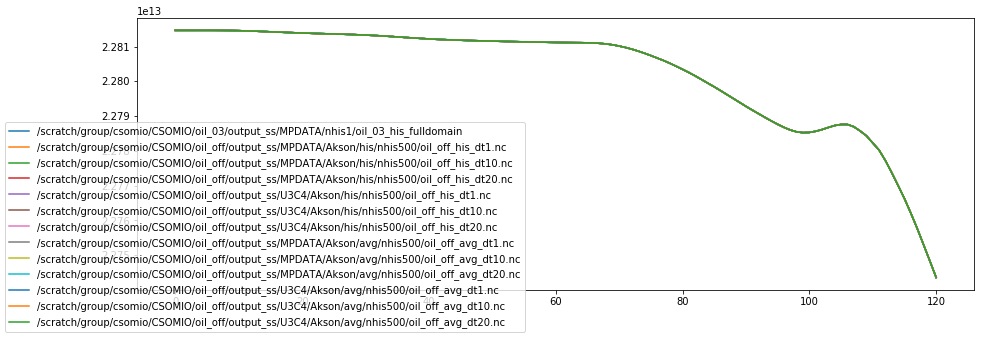

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# for loc in locson:
    # loc = '%s/output_ss/%s/nhis%i/oil_03_%s_fulldomain' % (baseon, 'MPDATA', 1, 'his')
loc = locson[0]
ds = xr.open_zarr(loc, decode_times=False, chunks=chunks)
# ds['ocean_time'] = (ds.ocean_time - ds.ocean_time[0])/86400
dyesumon = ds.dye_01.sum(('s_rho', 'eta_rho', 'xi_rho'))

ax.plot(dyesumon, label=loc)

dftracer = pd.DataFrame(index=)


# OFFLINE

for loc in locsoff:
    # loc = '%s/output_ss/%s/nhis%i/oil_03_%s_fulldomain' % (baseon, 'MPDATA', 1, 'his')
# loc = locsoff[0]
    dsoff = xr.open_dataset(loc, decode_times=False, chunks=chunks)
    # dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

    dsoff = add_depths(dsoff)
    dsoff, grid = setup_grid(dsoff)  
    dzoff = grid.diff(dsoff.z_w, 's')
    dx = 1/dsoff.pm
    dy = 1/dsoff.pn

    dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
    # dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
    #             xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
    # interpolate to match online run
    # dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)  
    dyesumoff = ds.dye_01.sum(('s_rho', 'eta_rho', 'xi_rho'))


    ax.plot(dyesumoff, label=loc)


fig.legend(loc='lower left')

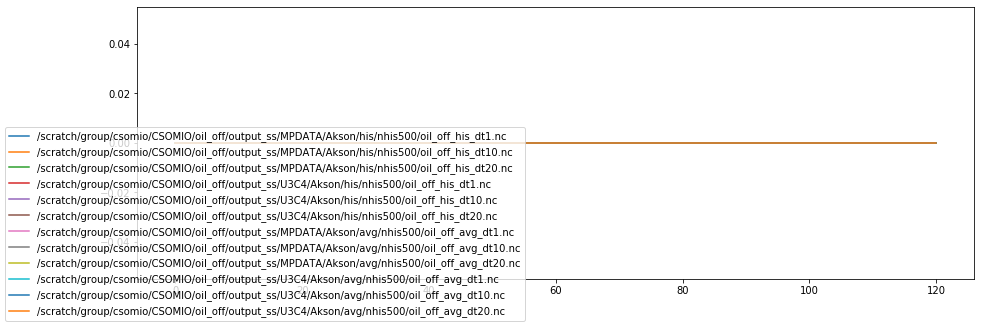

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# for loc in locson:
    # loc = '%s/output_ss/%s/nhis%i/oil_03_%s_fulldomain' % (baseon, 'MPDATA', 1, 'his')
loc = locson[0]
ds = xr.open_zarr(loc, decode_times=False, chunks=chunks)
# ds['ocean_time'] = (ds.ocean_time - ds.ocean_time[0])/86400
dyesumon = ds.dye_01.sum(('s_rho', 'eta_rho', 'xi_rho'))

# ax.plot(dyesumon, label=loc)


# OFFLINE

for loc in locsoff:
    # loc = '%s/output_ss/%s/nhis%i/oil_03_%s_fulldomain' % (baseon, 'MPDATA', 1, 'his')
# loc = locsoff[0]
    dsoff = xr.open_dataset(loc, decode_times=False, chunks=chunks)
    # dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

    dsoff = add_depths(dsoff)
    dsoff, grid = setup_grid(dsoff)  
    dzoff = grid.diff(dsoff.z_w, 's')
    dx = 1/dsoff.pm
    dy = 1/dsoff.pn

    dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
    # dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
    #             xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
    # interpolate to match online run
    # dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)  
    dyesumoff = ds.dye_01.sum(('s_rho', 'eta_rho', 'xi_rho'))


    ax.plot(dyesumoff-dyesumon, label=loc)


fig.legend(loc='lower left')

## Read in times for runs from log files

Both wall times and computational times

Online:

In [58]:


whichadvects = ['MPDATA']#, 'U3C4']
nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

dftimeon = pd.DataFrame(index=nhiss)

for whichadvect in whichadvects:
    Files = glob('%s/log/ss_%s_nhis*.*' % (baseon,whichadvect))
    Files = [File for File in Files if not 'single' in File]
    
    for File in Files:

        f = open(File, "r")
        lines = f.readlines()
        start = pd.Timestamp(lines[2])
        stop = pd.Timestamp(lines[-1].split('DONE...')[-1])
        walltime = stop - start

        comptime = float([line for line in lines if "All percentages are with respect to total time = " in line][0].split('=')[-1])

        namewt = '%s_walltime [s]' % (whichadvect)
        namect = '%s_comptime [s]' % whichadvect

        nhis = int(File.split('nhis')[1].split('.')[0])

        dftimeon.loc[nhis,namewt] = walltime.total_seconds()  # seconds
        dftimeon.loc[nhis,namect] = comptime  # seconds
dftimeon    

,MPDATA_walltime [s],MPDATA_comptime [s]
1,33709.0,2825931.469
2,20716.0,1737185.114
5,10006.0,839068.508
10,9456.0,793547.343
20,5464.0,458570.268
50,4599.0,386043.619
100,4289.0,360110.516
200,4103.0,344449.453
500,4032.0,338551.199
1000,4665.0,391777.237


Offline

In [90]:
whichadvects = ['MPDATA']#, 'U3C4']
nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
dts = [1,2,5,10,20]

rowslist = []
for whichadvect in whichadvects:
    Files = glob('%s/log/ss_%s_Akson_his_nhis*_dt*.*' % (baseoff,whichadvect))
    Files = [File for File in Files if not 'single' in File and not 'onlinewasU3C4' in File and not 'B' in File
            and 'nhis5_dt2' not in File and 'nhis50_dt20' not in File]
    
    for File in Files:

        dict1 = {}
        f = open(File, "r")
        lines = f.readlines()
        start = pd.Timestamp(lines[2])
        stop = pd.Timestamp(lines[-1].split('DONE...')[-1])
        walltime = stop - start

        comptime = float([line for line in lines if "All percentages are with respect to total time = " in line][0].split('=')[-1])

        namewt = '%s_walltime [s]' % (whichadvect)
        namect = '%s_comptime [s]' % whichadvect

        nhis = int(File.split('nhis')[1].split('_')[0])
        dt = int(File.split('dt')[1].split('.')[0])
        
        dict1['nhis'] = nhis
        dict1['dt'] = dt
        dict1[namewt] = walltime.total_seconds()  # seconds
        dict1[namect] = comptime  # seconds
        rowslist.append(dict1)

dftimeoff = pd.DataFrame(rowslist)


In [91]:
dftimeoff

,nhis,dt,MPDATA_walltime [s],MPDATA_comptime [s]
0,20,2,4106.0,57129.455
1,5000,10,586.0,8186.131
2,50,50,386.0,5284.439
3,200,1,6983.0,97590.946
4,100,10,715.0,9962.031
5,50,2,3264.0,45581.358
6,1000,10,664.0,9280.589
7,10,5,2654.0,36503.187
8,2000,10,659.0,9212.880
9,200,20,765.0,10366.869
